In [1]:
# Check for CUDA availability and set the device
import torch
import os

# Check if CUDA is available
is_cuda_available = torch.cuda.is_available()
device = torch.device("cuda" if is_cuda_available else "cpu")

# Print device information
print(f"Using device: {device}")
if is_cuda_available:
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    # Set CUDA device visibility if needed
    # os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using device: cuda
CUDA Device: NVIDIA GeForce RTX 4070
CUDA Version: 12.8


In [2]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("nojedag/xlm-roberta-finetuned-financial-news-sentiment-analysis-european")
model = AutoModelForSequenceClassification.from_pretrained("nojedag/xlm-roberta-finetuned-financial-news-sentiment-analysis-european")

# Move model to the appropriate device (GPU if available)
model = model.to(device)
print(f"Model moved to {device}")

Model moved to cuda


In [3]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": (preds == labels).mean(),
    }

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True)

def get_preds_and_labels(eval_output):
    logits = eval_output.predictions
    labels = eval_output.label_ids
    preds = np.argmax(logits, axis=1)
    return preds, labels

def get_probabilities(eval_output):
    """Extract probability scores from model output"""
    logits = eval_output.predictions
    # Apply softmax to get probabilities
    probabilities = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)
    return probabilities

TARGET_LABELS = ["neutral", "positive", "negative"]

In [4]:
from datasets import load_dataset
dataset = load_dataset("nojedag/financial_phrasebank_multilingual_augmented")
# Apply tokenization to the dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)

README.md:   0%|          | 0.00/840 [00:00<?, ?B/s]

(…)-00000-of-00001-d5434a0f6f056c78.parquet:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

(…)-00000-of-00001-c8615668d9034686.parquet:   0%|          | 0.00/734k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/19358 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8310 [00:00<?, ? examples/s]

Map:   0%|          | 0/19358 [00:00<?, ? examples/s]

Map:   0%|          | 0/8310 [00:00<?, ? examples/s]

In [5]:
from transformers import Trainer, TrainingArguments

# 4. Initialize Trainer
trainer = Trainer(
    model=model,
    args=TrainingArguments(
        per_device_eval_batch_size=32,
        output_dir="./results",
        do_eval=True,
        no_cuda=not is_cuda_available,  # Use CUDA if available
        fp16=True,  # Enable mixed precision training
    ),
    compute_metrics=compute_metrics,
)

In [6]:
# 8. Plot it
def plot_confusion_matrix(cm, labels, title="Confusion Matrix"):
    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    plt.title(title)
    plt.show()

In [7]:
def plot_roc_auc_curves(labels, probabilities, lang_name, n_classes=3):
    """
    Plot ROC-AUC curves for multiclass classification.
    
    Args:
        labels: True labels
        probabilities: Predicted probabilities for each class
        lang_name: Name of the language for the title
        n_classes: Number of classes (default: 3 for negative, neutral, positive)
    """
    # Binarize the output
    labels_bin = label_binarize(labels, classes=[0, 1, 2])
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], probabilities[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_bin.ravel(), probabilities.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    
    # Define colors and class names
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    class_names = ['Negative', 'Neutral', 'Positive']
    
    # Plot ROC curve for each class
    for i, color, class_name in zip(range(n_classes), colors, class_names):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label=f'{class_name} (AUC = {roc_auc[i]:.2f})')
    
    # Plot micro-average ROC curve
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4,
            label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})')
    
    # Plot diagonal line (random classifier)
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC-AUC Curves - {lang_name}', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print AUC scores
    print(f"\n{lang_name} ROC-AUC Scores:")
    for i, class_name in enumerate(class_names):
        print(f"  {class_name}: {roc_auc[i]:.4f}")
    print(f"  Micro-average: {roc_auc['micro']:.4f}")
    
    return roc_auc

In [8]:
# Utility functions for language-specific evaluation

def evaluate_language(trainer, tokenized_dataset, lang_code, lang_name):
    """
    Evaluate model performance for a specific language.
    
    Args:
        trainer: The Transformers Trainer object
        tokenized_dataset: The tokenized dataset
        lang_code: Integer code for the language (0=English, 1=French, 2=German, 3=Spanish)
        lang_name: String name of the language for display
    
    Returns:
        tuple: (predictions, labels, confusion_matrix, probabilities, roc_auc_scores)
    """
    # Filter dataset for specific language
    filtered_dataset = tokenized_dataset["test"].filter(lambda x: x["lang"] == lang_code)
    
    # Run evaluation
    eval_output = trainer.predict(filtered_dataset)
    preds, labels = get_preds_and_labels(eval_output)
    probabilities = get_probabilities(eval_output)
    
    # Compute confusion matrix
    cm = confusion_matrix(labels, preds)
    
    # Plot confusion matrix
    plot_confusion_matrix(cm, [0, 1, 2], title=f"{lang_name} Confusion Matrix")
    
    # Plot ROC-AUC curves
    roc_auc_scores = plot_roc_auc_curves(labels, probabilities, lang_name)
    
    # Print classification report
    print(f"\n{lang_name} Classification Report:")
    print(classification_report(labels, preds, target_names=["negative", "neutral", "positive"]))
    
    return preds, labels, cm, probabilities, roc_auc_scores

def evaluate_all_languages(trainer, tokenized_dataset):
    """
    Evaluate model performance for all languages.
    
    Args:
        trainer: The Transformers Trainer object
        tokenized_dataset: The tokenized dataset
    
    Returns:
        dict: Results for each language
    """
    languages = {
        0: "English",
        1: "French", 
        2: "German",
        3: "Spanish"
    }
    
    results = {}
    
    for lang_code, lang_name in languages.items():
        print(f"\n{'='*50}")
        print(f"Evaluating {lang_name} samples")
        print(f"{'='*50}")
        
        preds, labels, cm, probabilities, roc_auc_scores = evaluate_language(trainer, tokenized_dataset, lang_code, lang_name)
        results[lang_name] = {
            'predictions': preds,
            'labels': labels,
            'confusion_matrix': cm,
            'probabilities': probabilities,
            'roc_auc_scores': roc_auc_scores
        }
    
    return results

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: nestorojedagonzalez (nojeda) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Currently logged in as: nestorojedagonzalez (nojeda) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


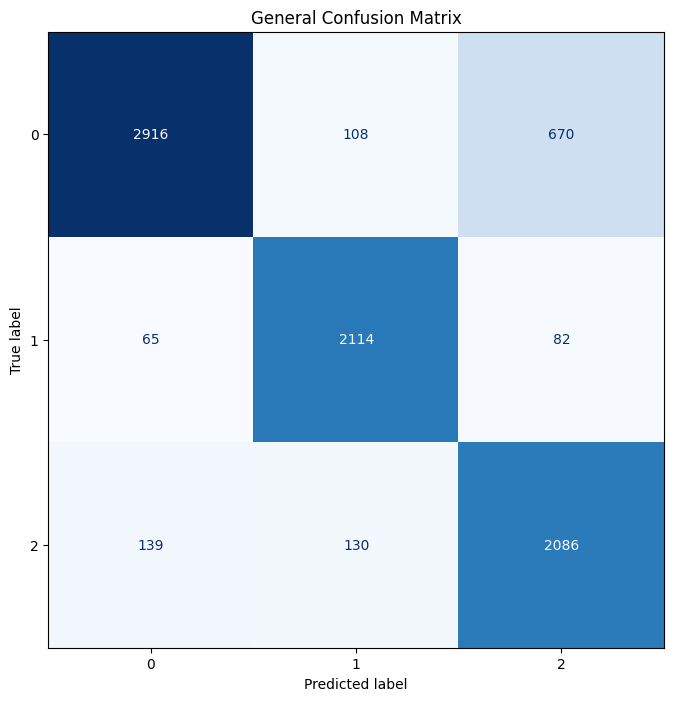

In [9]:
# 5. Run evaluation to get raw preds & labels
eval_output = trainer.predict(tokenized_dataset["test"])
preds, labels = get_preds_and_labels(eval_output)
# 7. Compute confusion matrix
cm = confusion_matrix(labels, preds)
# If you want normalized counts, pass `normalize='true'` or `normalize='pred'` etc.
plot_confusion_matrix(cm, [0, 1, 2], title="General Confusion Matrix")

In [10]:
# Overall evaluation with F1 score, recall, precision
from sklearn.metrics import classification_report
print("Overall Classification Report:")
print(classification_report(labels, preds, target_names=["negative", "neutral", "positive"]))

Overall Classification Report:
              precision    recall  f1-score   support

    negative       0.93      0.79      0.86      3694
     neutral       0.90      0.93      0.92      2261
    positive       0.74      0.89      0.80      2355

    accuracy                           0.86      8310
   macro avg       0.86      0.87      0.86      8310
weighted avg       0.87      0.86      0.86      8310



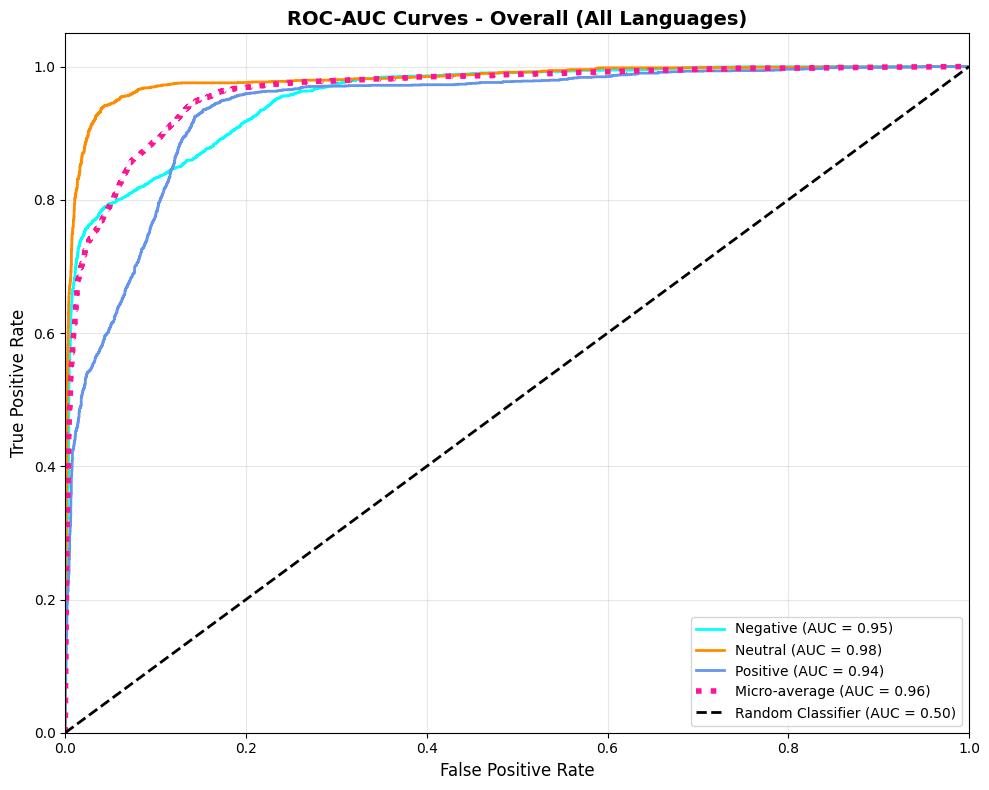


Overall (All Languages) ROC-AUC Scores:
  Negative: 0.9545
  Neutral: 0.9815
  Positive: 0.9375
  Micro-average: 0.9629

Overall Macro-averaged ROC-AUC Score: 0.9578


In [11]:
# Generate ROC-AUC curves for overall evaluation
overall_probabilities = get_probabilities(eval_output)
overall_roc_auc_scores = plot_roc_auc_curves(labels, overall_probabilities, "Overall (All Languages)")

# Print overall macro-averaged ROC-AUC score
overall_macro_auc = roc_auc_score(labels, overall_probabilities, multi_class='ovr', average='macro')
print(f"\nOverall Macro-averaged ROC-AUC Score: {overall_macro_auc:.4f}")


Evaluating English samples


Filter:   0%|          | 0/8310 [00:00<?, ? examples/s]

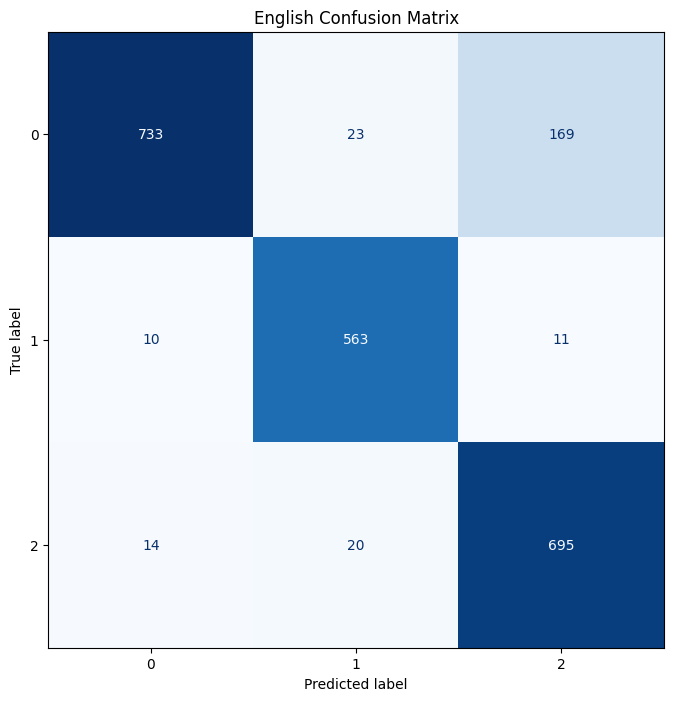

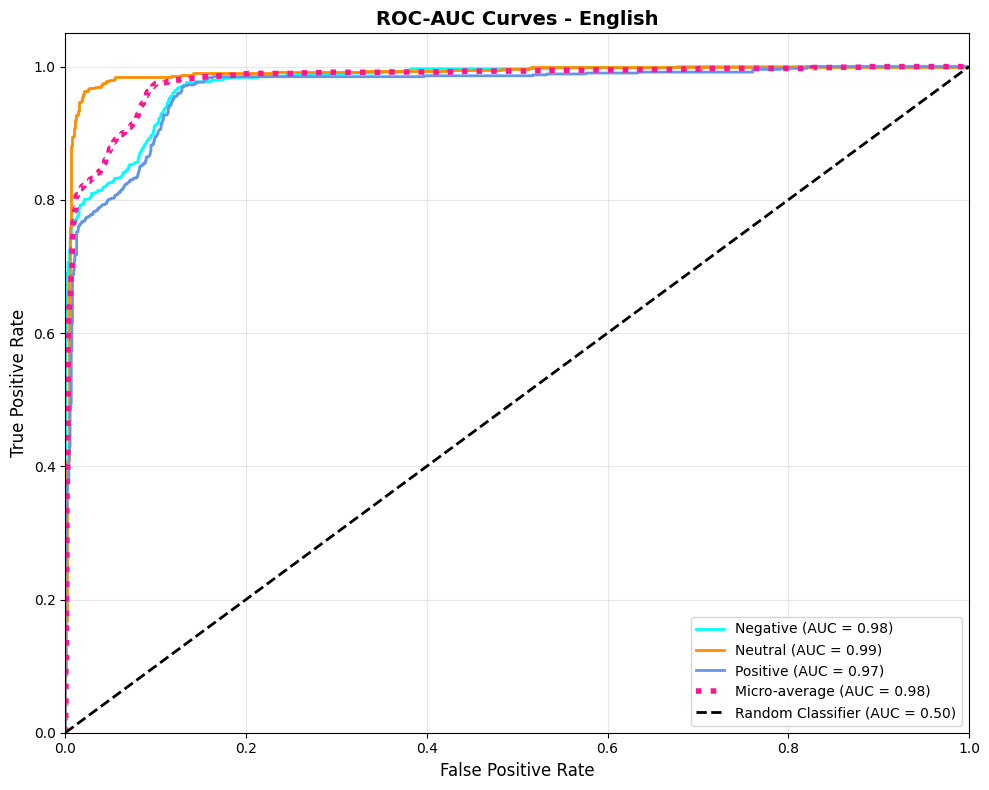


English ROC-AUC Scores:
  Negative: 0.9761
  Neutral: 0.9904
  Positive: 0.9672
  Micro-average: 0.9793

English Classification Report:
              precision    recall  f1-score   support

    negative       0.97      0.79      0.87       925
     neutral       0.93      0.96      0.95       584
    positive       0.79      0.95      0.87       729

    accuracy                           0.89      2238
   macro avg       0.90      0.90      0.89      2238
weighted avg       0.90      0.89      0.89      2238


Evaluating French samples


Filter:   0%|          | 0/8310 [00:00<?, ? examples/s]

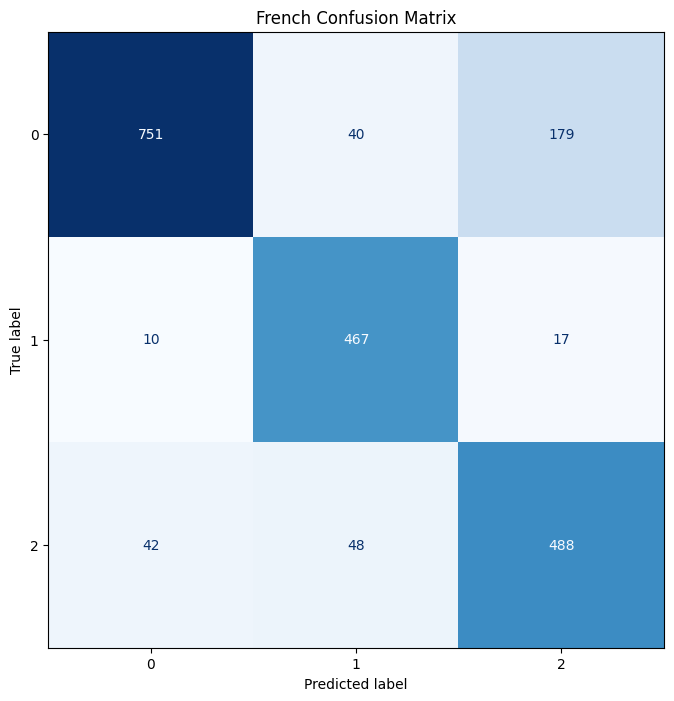

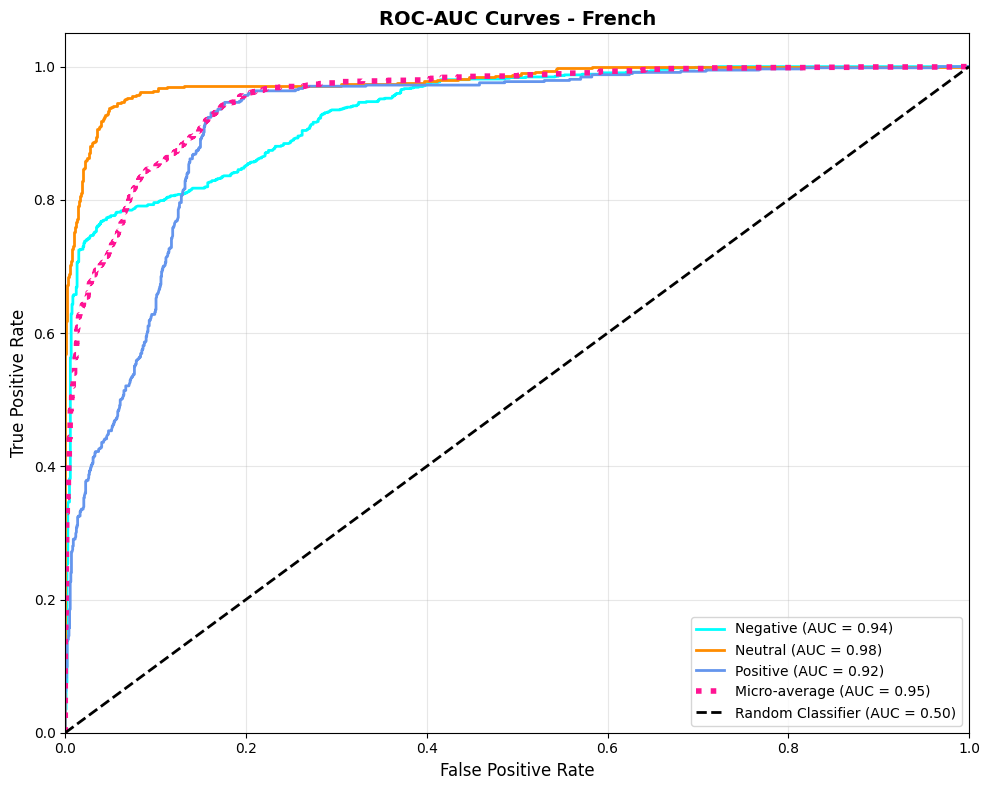


French ROC-AUC Scores:
  Negative: 0.9359
  Neutral: 0.9788
  Positive: 0.9180
  Micro-average: 0.9533

French Classification Report:
              precision    recall  f1-score   support

    negative       0.94      0.77      0.85       970
     neutral       0.84      0.95      0.89       494
    positive       0.71      0.84      0.77       578

    accuracy                           0.84      2042
   macro avg       0.83      0.85      0.84      2042
weighted avg       0.85      0.84      0.84      2042


Evaluating German samples


Filter:   0%|          | 0/8310 [00:00<?, ? examples/s]

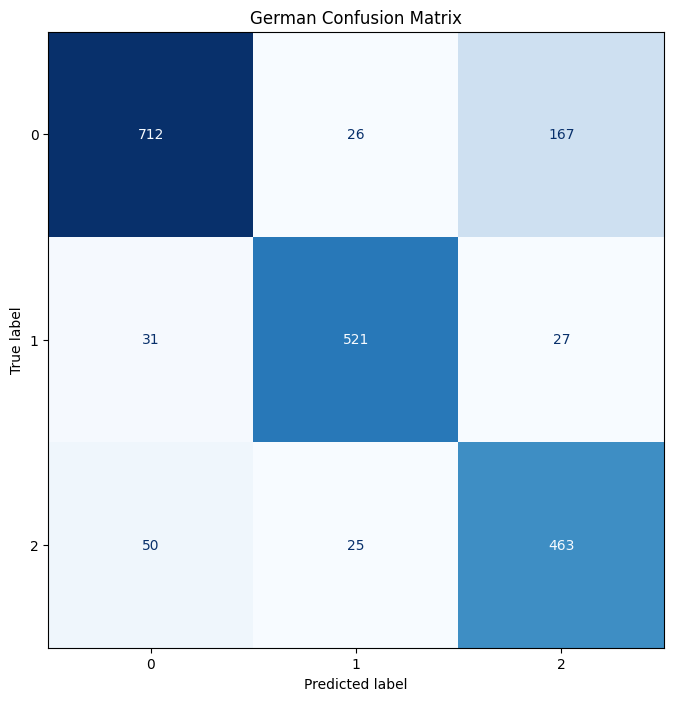

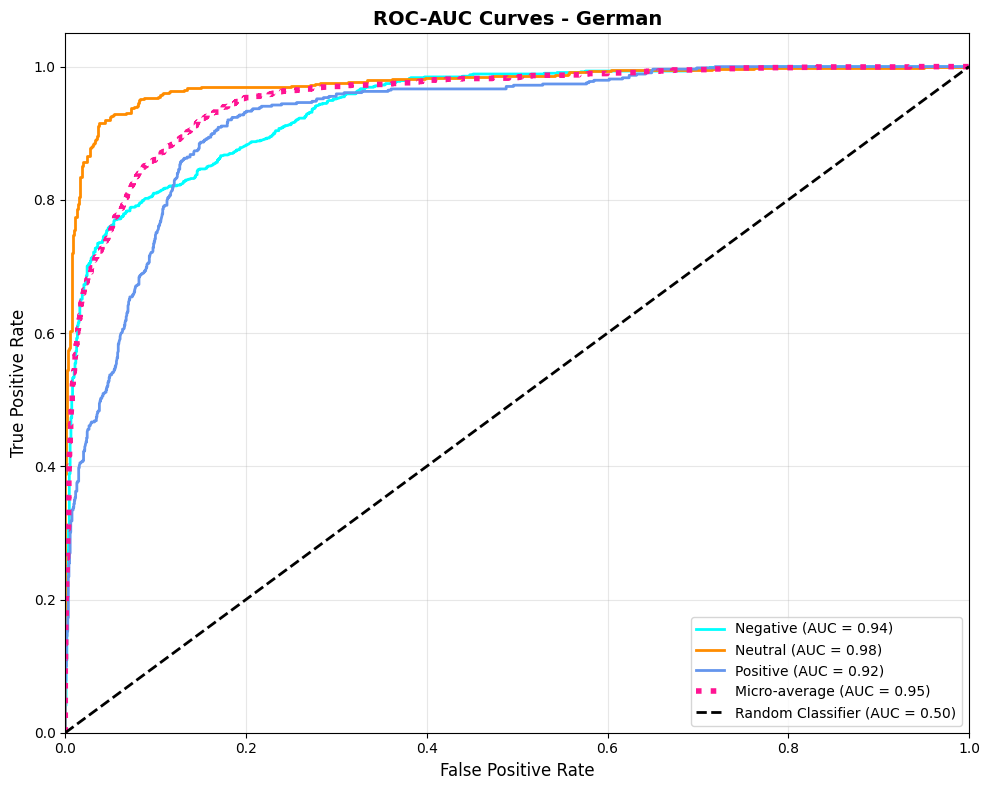


German ROC-AUC Scores:
  Negative: 0.9408
  Neutral: 0.9757
  Positive: 0.9242
  Micro-average: 0.9532

German Classification Report:
              precision    recall  f1-score   support

    negative       0.90      0.79      0.84       905
     neutral       0.91      0.90      0.91       579
    positive       0.70      0.86      0.77       538

    accuracy                           0.84      2022
   macro avg       0.84      0.85      0.84      2022
weighted avg       0.85      0.84      0.84      2022


Evaluating Spanish samples


Filter:   0%|          | 0/8310 [00:00<?, ? examples/s]

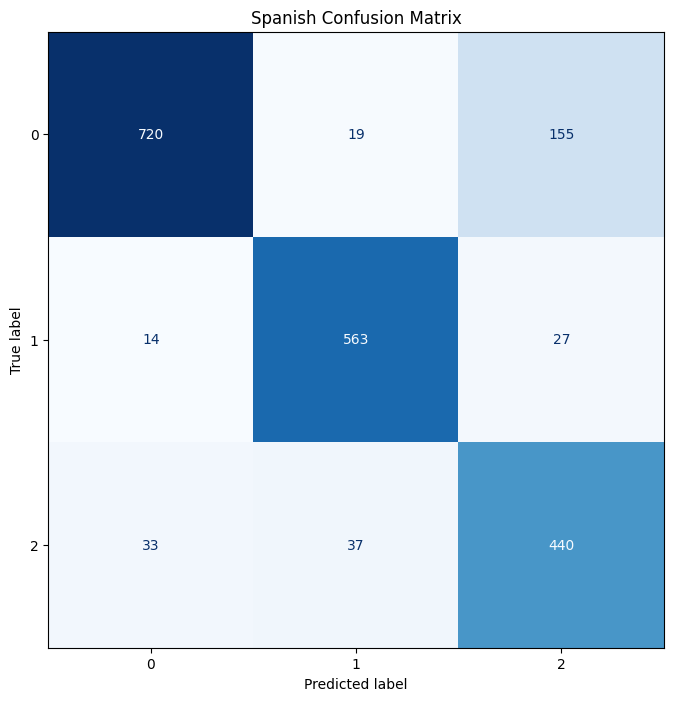

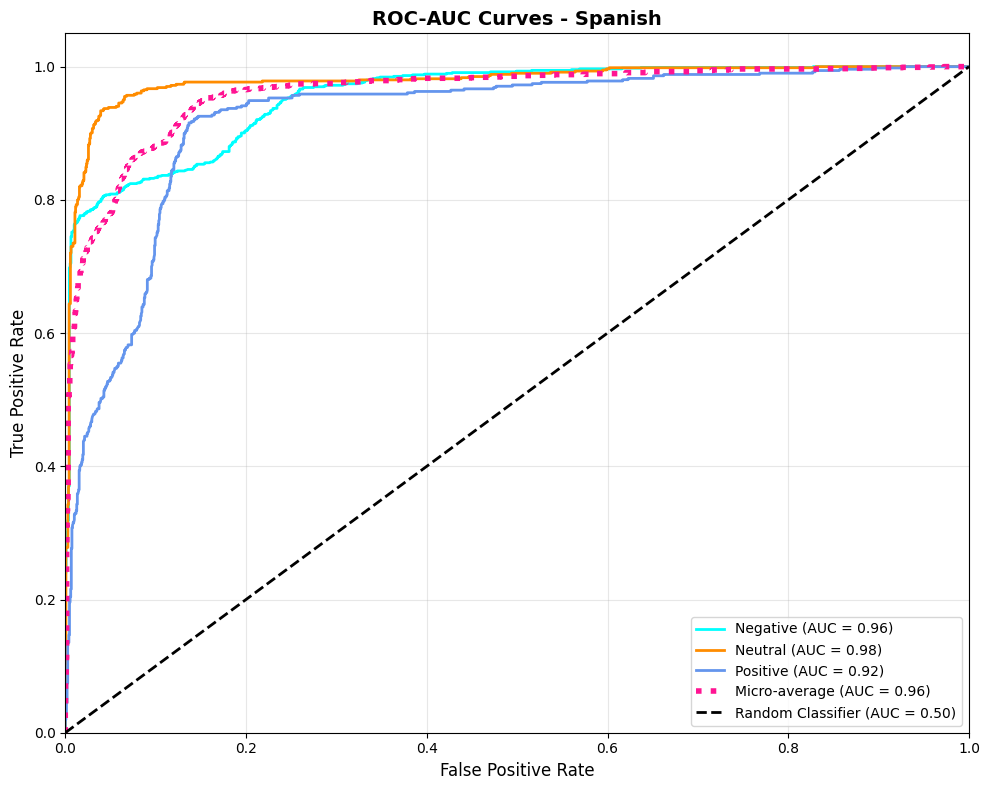


Spanish ROC-AUC Scores:
  Negative: 0.9552
  Neutral: 0.9789
  Positive: 0.9224
  Micro-average: 0.9603

Spanish Classification Report:
              precision    recall  f1-score   support

    negative       0.94      0.81      0.87       894
     neutral       0.91      0.93      0.92       604
    positive       0.71      0.86      0.78       510

    accuracy                           0.86      2008
   macro avg       0.85      0.87      0.86      2008
weighted avg       0.87      0.86      0.86      2008



In [12]:
# Evaluate model performance for all languages using the utility functions
language_results = evaluate_all_languages(trainer, tokenized_dataset)


ROC-AUC SCORES SUMMARY ACROSS ALL LANGUAGES
Language  Negative AUC  Neutral AUC  Positive AUC  Micro-Average AUC  Macro-Average AUC
 English        0.9761       0.9904        0.9672             0.9793             0.9779
  French        0.9359       0.9788        0.9180             0.9533             0.9442
  German        0.9408       0.9757        0.9242             0.9532             0.9469
 Spanish        0.9552       0.9789        0.9224             0.9603             0.9521


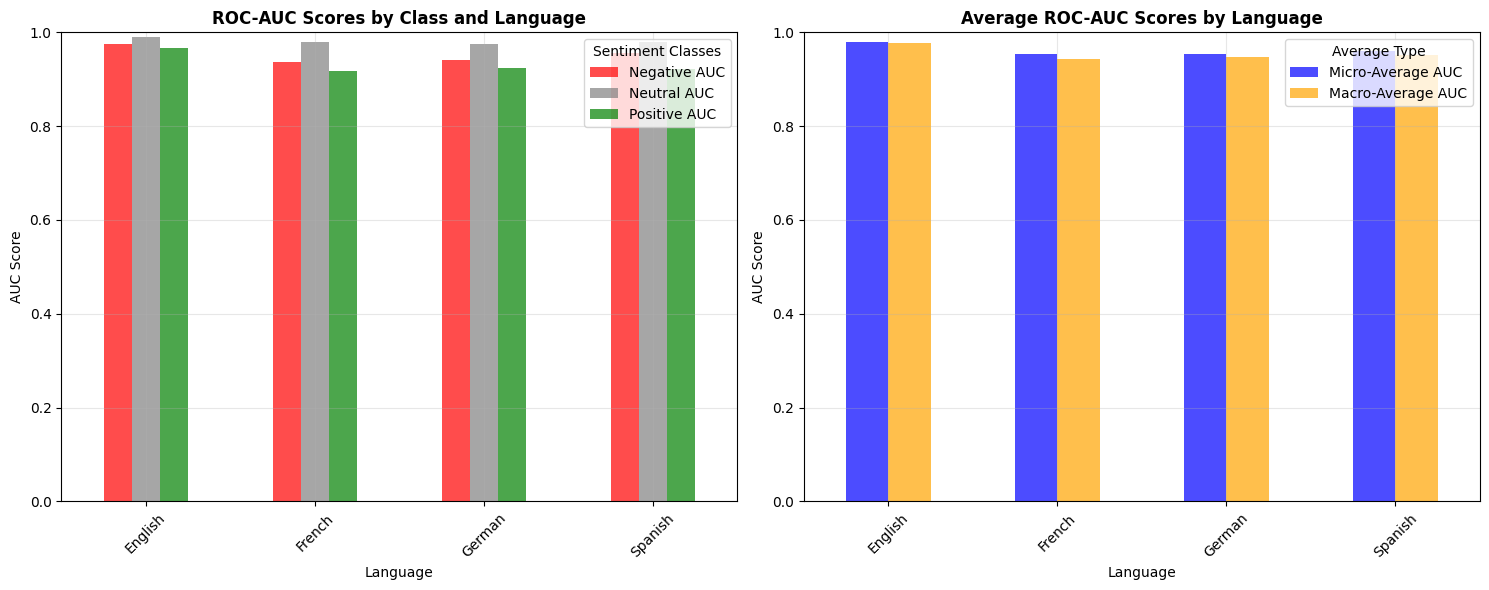


Best performing language (Macro-Average AUC): English (0.9779)
Worst performing language (Macro-Average AUC): French (0.9442)
Performance difference: 0.0337


In [13]:
# Create a summary comparison of ROC-AUC scores across all languages
import pandas as pd

def create_roc_auc_summary(language_results):
    """
    Create a summary table of ROC-AUC scores for all languages.
    
    Args:
        language_results: Dictionary containing results for each language
    
    Returns:
        DataFrame: Summary table of ROC-AUC scores
    """
    summary_data = []
    
    for lang_name, results in language_results.items():
        roc_auc_scores = results['roc_auc_scores']
        
        # Calculate macro-average ROC-AUC
        labels = results['labels']
        probabilities = results['probabilities']
        macro_auc = roc_auc_score(labels, probabilities, multi_class='ovr', average='macro')
        
        summary_data.append({
            'Language': lang_name,
            'Negative AUC': roc_auc_scores[0],
            'Neutral AUC': roc_auc_scores[1],
            'Positive AUC': roc_auc_scores[2],
            'Micro-Average AUC': roc_auc_scores['micro'],
            'Macro-Average AUC': macro_auc
        })
    
    return pd.DataFrame(summary_data)

# Generate and display the ROC-AUC summary
roc_auc_summary = create_roc_auc_summary(language_results)
print("\n" + "="*80)
print("ROC-AUC SCORES SUMMARY ACROSS ALL LANGUAGES")
print("="*80)
print(roc_auc_summary.to_string(index=False, float_format='%.4f'))

# Plot comparative ROC-AUC scores
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Individual class AUC scores
class_cols = ['Negative AUC', 'Neutral AUC', 'Positive AUC']
roc_auc_summary[class_cols].plot(kind='bar', ax=axes[0], color=['red', 'gray', 'green'], alpha=0.7)
axes[0].set_title('ROC-AUC Scores by Class and Language', fontweight='bold')
axes[0].set_xlabel('Language')
axes[0].set_ylabel('AUC Score')
axes[0].set_xticklabels(roc_auc_summary['Language'], rotation=45)
axes[0].legend(title='Sentiment Classes')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(0, 1)

# Plot 2: Average AUC scores
avg_cols = ['Micro-Average AUC', 'Macro-Average AUC']
roc_auc_summary[avg_cols].plot(kind='bar', ax=axes[1], color=['blue', 'orange'], alpha=0.7)
axes[1].set_title('Average ROC-AUC Scores by Language', fontweight='bold')
axes[1].set_xlabel('Language')
axes[1].set_ylabel('AUC Score')
axes[1].set_xticklabels(roc_auc_summary['Language'], rotation=45)
axes[1].legend(title='Average Type')
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Print best and worst performing languages
best_macro = roc_auc_summary.loc[roc_auc_summary['Macro-Average AUC'].idxmax()]
worst_macro = roc_auc_summary.loc[roc_auc_summary['Macro-Average AUC'].idxmin()]

print(f"\nBest performing language (Macro-Average AUC): {best_macro['Language']} ({best_macro['Macro-Average AUC']:.4f})")
print(f"Worst performing language (Macro-Average AUC): {worst_macro['Language']} ({worst_macro['Macro-Average AUC']:.4f})")
print(f"Performance difference: {best_macro['Macro-Average AUC'] - worst_macro['Macro-Average AUC']:.4f}")

## ROC-AUC Analysis Summary

The ROC-AUC (Receiver Operating Characteristic - Area Under Curve) analysis provides insights into the model's performance across different languages and sentiment classes:

### Key Metrics Explained:
- **Individual Class AUC**: Performance for each sentiment class (Negative, Neutral, Positive)
- **Micro-Average AUC**: Overall performance considering class imbalance
- **Macro-Average AUC**: Average performance across all classes (treats all classes equally)

### Performance Interpretation:
- **AUC = 1.0**: Perfect classifier
- **AUC = 0.5**: Random classifier (no discriminative ability)
- **AUC < 0.5**: Worse than random (rarely occurs in practice)

### Language-Specific Insights:
The analysis above shows how well the XLM-RoBERTa model performs sentiment classification across different European languages, highlighting any language-specific biases or strengths in the multilingual model.